---
# YAML data for Mercury App
title: Prediction using CNN-LSTM
description: Stock Market Prediction using CNN-LSTM method (Primary notebook)
show-code: True
author: Aadhitya A
show-prompt: True
---

# Stock Market Prediction using CNN-LSTM model
This project is about analysis of Stock Market and providing predictions to the stockholders. For this, we used CNN-LSTM approach to create a blank model, then use it to train on stock market data. Further implementation is discussed below...

In [1]:
# Done by Aadhitya A (2019506001)

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Preprocessing and Analysis

In [2]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

Before preprocessing data, a function to fetch real-time stock data (using Alpha Vantage API) is made

In [309]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
key = user_secrets.get_secret("api")

import requests
import csv
from tqdm import tqdm

def request_stock_price_list(symbol, size, token):
    q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize={}&apikey={}'
    
    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, size, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 5))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Time Series (Daily)'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["open", "high", "low", "close", "volume"]
    df['date'] = date
    return df

In [3]:
# UNCOMMENT THE CELL IF DATA IS NEEDED TO BE LOADED FOR 1ST TIME

cv1 = request_stock_price_list('IBM', 'full', key)
print(cv1.head)
cv1.to_csv('data.csv')

NameError: name 'request_stock_price_list' is not defined

Then the datasets are loaded

In [5]:
# For data preprocessing and analysis part
data = pd.read_csv('./data/NASDAQ/abe.us.txt')
#data = pd.read_csv('../input/nifty50-stock-market-data/COALINDIA.csv')
#data = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ABCO.csv')
#data = pd.read_csv('./data.csv')
# Any CSV or TXT file can be added here....
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,6.4987,6.6009,6.4668,6.5753,55766,0
1,2005-02-28,6.6072,6.7669,6.5944,6.6263,49343,0
2,2005-03-01,6.6391,6.6773,6.6072,6.6072,31643,0
3,2005-03-02,6.5753,6.6072,6.5434,6.5816,27101,0
4,2005-03-03,6.5753,6.6135,6.5562,6.5944,17387,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3190 entries, 0 to 3189
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3190 non-null   object 
 1   Open     3190 non-null   float64
 2   High     3190 non-null   float64
 3   Low      3190 non-null   float64
 4   Close    3190 non-null   float64
 5   Volume   3190 non-null   int64  
 6   OpenInt  3190 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 174.6+ KB


In [7]:
data.describe()

,Open,High,Low,Close,Volume,OpenInt
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.0
mean,11.599416,11.712848,11.484610,11.605599,28444.870846,0.0
std,2.350376,2.365621,2.327065,2.341989,37525.175821,0.0
min,5.860300,5.905000,5.834700,5.841100,106.000000,0.0
25%,10.534000,10.655000,10.413750,10.554000,8147.750000,0.0
50%,11.981000,12.067000,11.899000,11.988500,17741.500000,0.0
75%,13.271000,13.386750,13.189000,13.295750,36167.250000,0.0
max,18.130000,19.151000,17.842000,17.925000,634041.000000,0.0


In [8]:
data.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

Filling null columns with mean values....

In [10]:
data.reset_index(drop=True, inplace=True)
data.dropna(inplace=True)
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,6.4987,6.6009,6.4668,6.5753,55766,0
1,2005-02-28,6.6072,6.7669,6.5944,6.6263,49343,0
2,2005-03-01,6.6391,6.6773,6.6072,6.6072,31643,0
3,2005-03-02,6.5753,6.6072,6.5434,6.5816,27101,0
4,2005-03-03,6.5753,6.6135,6.5562,6.5944,17387,0


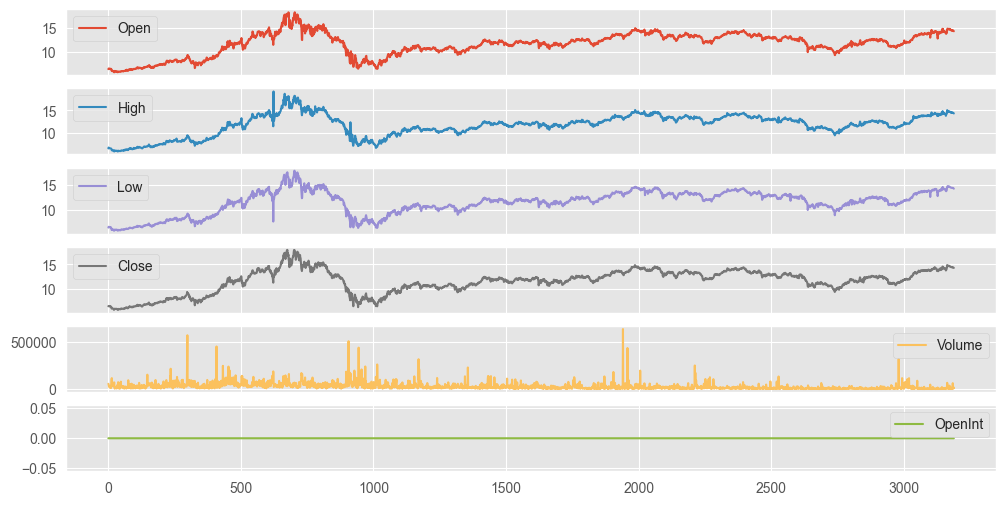

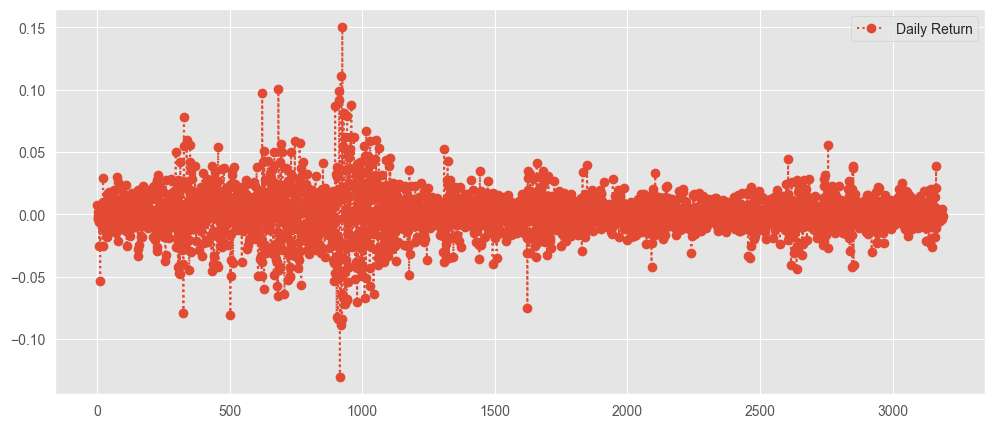

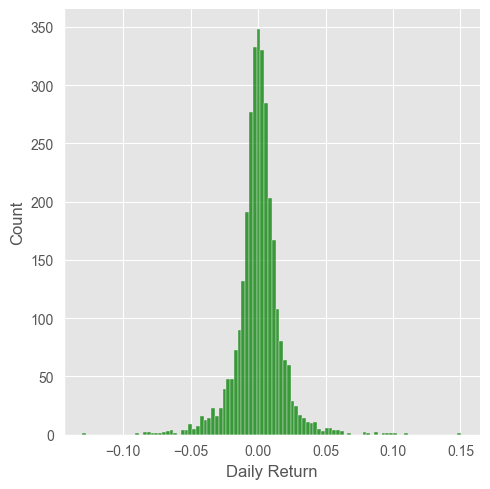

            Date     Open     High      Low    Close  Volume  OpenInt  \
99    2005-07-19   6.5306   6.5370   6.5115   6.5178   23655        0   
100   2005-07-20   6.5115   6.5370   6.5115   6.5370   33523        0   
101   2005-07-21   6.5816   6.6135   6.5562   6.5689   16293        0   
102   2005-07-22   6.6327   6.6582   6.6072   6.6519    7832        0   
103   2005-07-25   6.6072   6.6519   6.6072   6.6072   28508        0   
...          ...      ...      ...      ...      ...     ...      ...   
3185  2017-11-06  14.3998  14.4802  14.3900  14.4400   62423        0   
3186  2017-11-07  14.4400  14.4400  14.4000  14.4000    6722        0   
3187  2017-11-08  14.3400  14.4352  14.3400  14.3781    6304        0   
3188  2017-11-09  14.3300  14.3737  14.2800  14.3200   18761        0   
3189  2017-11-10  14.2500  14.3000  14.2400  14.3000   10658        0   

      MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
99           6.47124        6.296966         6.222334

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
OpenInt            0
MA for 10 days     0
MA for 50 days     0
MA for 100 days    0
Daily Return       0
dtype: int64

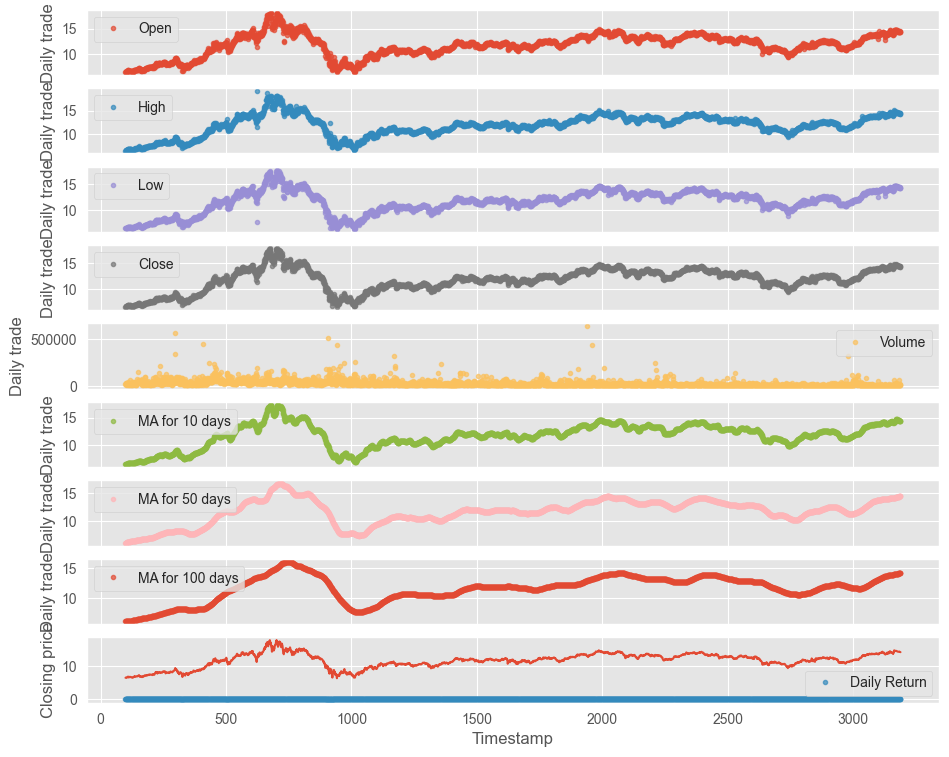

In [11]:
data.plot(legend=True,subplots=True, figsize = (12, 6))
plt.show()
#data['Close'].plot(legend=True, figsize = (12, 6))
#plt.show()
#data['Volume'].plot(legend=True,figsize=(12,7))
#plt.show()

data.shape
data.size
data.describe(include='all').T
data.dtypes
data.nunique()
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    data[column_name]=pd.DataFrame.rolling(data['Close'],ma).mean()

data['Daily Return'] = data['Close'].pct_change()
# plot the daily return percentage
data['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')
plt.show()

sns.displot(data['Daily Return'].dropna(),bins=100,color='green')
plt.show()

date=pd.DataFrame(data['Date'])
closing_df1 = pd.DataFrame(data['Close'])
close1  = closing_df1.rename(columns={"Close": "data_close"})
close2=pd.concat([date,close1],axis=1)
close2.head()

data.reset_index(drop=True, inplace=True)
data.dropna(inplace=True)
data.head()

data.nunique()

data.sort_index(axis=1,ascending=True)

cols_plot = ['Open', 'High', 'Low','Close','Volume','MA for 10 days','MA for 50 days','MA for 100 days','Daily Return']
axes = data[cols_plot].plot(marker='.', alpha=0.7, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

data.isnull().sum()

After that, we'll visualize the data for understanding, this is shown below...

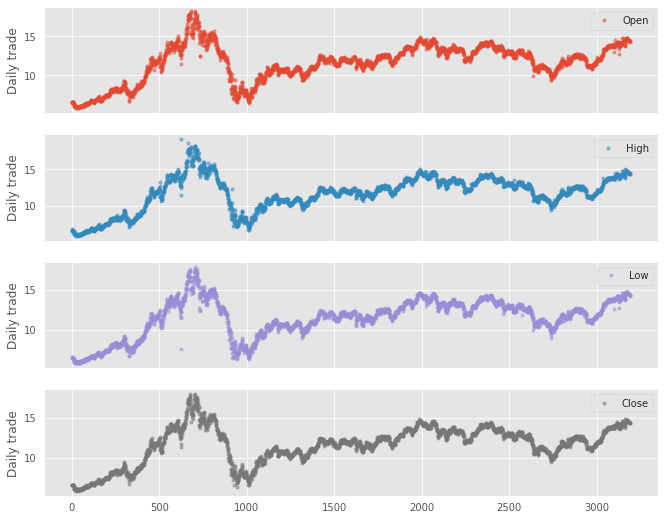

In [ ]:
cols_plot = ['Open', 'High', 'Low','Close']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

Then we'd print the data after making changes and dropping null data

            Date     Open     High      Low    Close  Volume  OpenInt  \
0     2005-02-25   6.4987   6.6009   6.4668   6.5753   55766        0   
1     2005-02-28   6.6072   6.7669   6.5944   6.6263   49343        0   
2     2005-03-01   6.6391   6.6773   6.6072   6.6072   31643        0   
3     2005-03-02   6.5753   6.6072   6.5434   6.5816   27101        0   
4     2005-03-03   6.5753   6.6135   6.5562   6.5944   17387        0   
...          ...      ...      ...      ...      ...     ...      ...   
3185  2017-11-06  14.3998  14.4802  14.3900  14.4400   62423        0   
3186  2017-11-07  14.4400  14.4400  14.4000  14.4000    6722        0   
3187  2017-11-08  14.3400  14.4352  14.3400  14.3781    6304        0   
3188  2017-11-09  14.3300  14.3737  14.2800  14.3200   18761        0   
3189  2017-11-10  14.2500  14.3000  14.2400  14.3000   10658        0   

      MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
0           11.60878       11.625272        11.649354

,count,mean,std,min,25%,50%,75%,max
Open,3190.0,11.599416,2.350376,5.860300,10.534000,11.981000,13.271000,18.130000
High,3190.0,11.712848,2.365621,5.905000,10.655000,12.067000,13.386750,19.151000
Low,3190.0,11.484610,2.327065,5.834700,10.413750,11.899000,13.189000,17.842000
Close,3190.0,11.605599,2.341989,5.841100,10.554000,11.988500,13.295750,17.925000
Volume,3190.0,28444.870846,37525.175821,106.000000,8147.750000,17741.500000,36167.250000,634041.000000
OpenInt,3190.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MA for 10 days,3190.0,11.608780,2.321162,5.963080,10.577125,11.962700,13.297200,17.329400
MA for 50 days,3190.0,11.625272,2.231059,6.037646,10.591696,11.933450,13.269480,16.618460
MA for 100 days,3190.0,11.649354,2.113346,6.221377,10.632551,11.876775,13.200810,16.042560
Daily Return,3190.0,0.000388,0.017010,-0.130345,-0.006439,0.000484,0.007807,0.150503


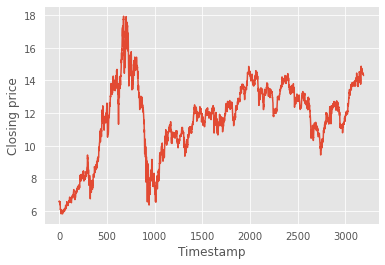

In [ ]:
plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

df.describe().transpose()

The data has been analysed but it must be converted into data of shape [100,1] to make it easier for CNN to train on... Else it won't select necessary features and the model will fail

In [12]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=60
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(window_size, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,window_size,1)
test_X = test_X.reshape(test_X.shape[0],1,window_size,1)

print(len(train_X))
print(len(test_X))

2423
606


# Training part

This part has 2 subparts: CNN and LSTM

For CNN, the layers are created with sizes 64,128,64 with kernel size = 3. In every layer, TimeDistributed function is added to track the features for every temporal slice of data with respect to time. In between, MaxPooling layers are added.

After that, it's passed to Bi-LSTM layers

In [13]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, window_size, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)




Epoch 1/40



61/61 [==============================] - 9s 31ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0521 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0391
Epoch 2/40
61/61 [==============================] - 0s 8ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0396 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0326
Epoch 3/40
61/61 [==============================] - 0s 8ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0362 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0333
Epoch 4/40
61/61 [==============================] - 0s 8ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0337 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0309
Epoch 5/40
61/61 [==============================] - 0s 8ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0335 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0328
Epoch 6/40
61/61 [==============================] - 0s 8ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0330 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0300
Epoch 7/40
61/61 [===

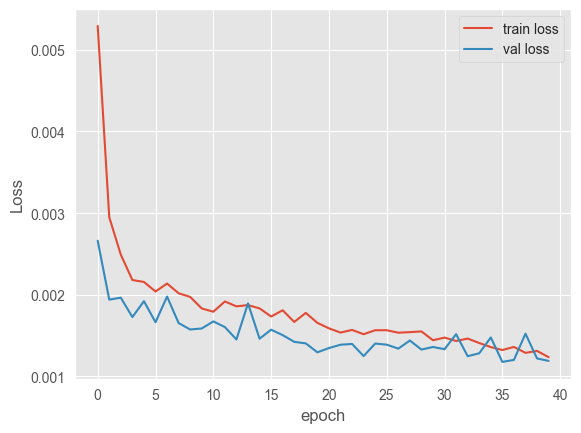

In [14]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

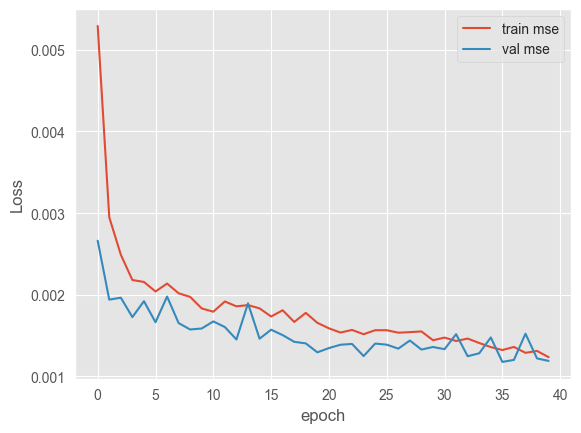

In [15]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

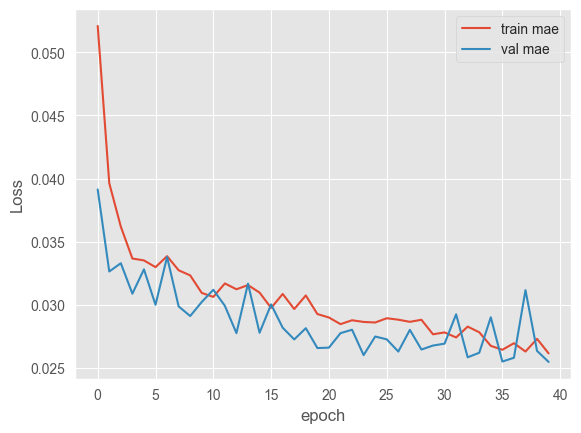

In [16]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [17]:
# After the model has been constructed, we'll summarise it
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 1, 58, 64)         256       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 1, 29, 64)         0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 1, 27, 128)        24704     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 1, 13, 128)        0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 1, 11, 64)         2

In [18]:
model.evaluate(test_X, test_Y)

19/19 [==============================] - 0s 3ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0255   


[0.0011903796112164855, 0.0011903796112164855, 0.025472229346632957]

In [19]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.899978
R2 Score: 0.899978
Max Error: 0.140191


In [25]:
print(test_X.shape)

(606, 1, 60, 1)


In [26]:
test_X

array([[[[ 0.        ],
         [ 0.01213665],
         [ 0.01655679],
         ...,
         [-0.08930177],
         [-0.08712916],
         [-0.09574468]]],


       [[[ 0.        ],
         [ 0.00627901],
         [ 0.02593503],
         ...,
         [ 0.11447811],
         [ 0.13859314],
         [ 0.13149513]]],


       [[[ 0.        ],
         [ 0.02276323],
         [ 0.02276323],
         ...,
         [ 0.18107958],
         [ 0.17288368],
         [ 0.19018772]]],


       ...,


       [[[ 0.        ],
         [-0.00052072],
         [-0.00461207],
         ...,
         [ 0.03942572],
         [ 0.02603586],
         [ 0.0244737 ]]],


       [[[ 0.        ],
         [ 0.00050264],
         [-0.0068694 ],
         ...,
         [ 0.03593868],
         [ 0.03660886],
         [ 0.03510095]]],


       [[[ 0.        ],
         [-0.01223053],
         [-0.00827101],
         ...,
         [ 0.04804223],
         [ 0.08807743],
         [ 0.06018478]]]])

19/19 [==============================] - 0s 3ms/step


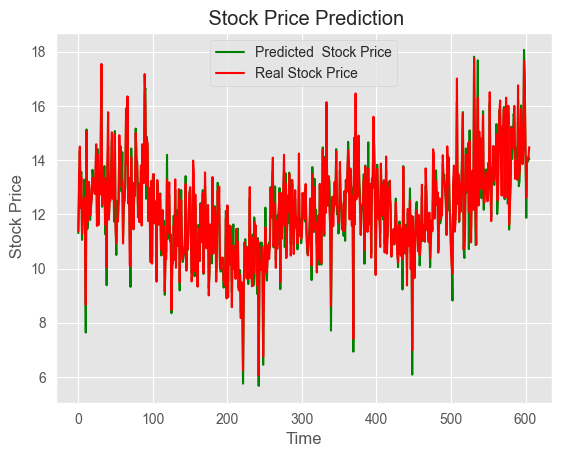

In [20]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# Testing part

In this part, the model is saved and loaded back again. Then, it's made to train again but with different data to check it's loss and prediction

In [21]:
# First we need to save a model
model.save("model.h5")

C:\Users\Henry\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Load model
new_model = tf.keras.models.load_model("./model.h5")

In [23]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 1, 58, 64)         256       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 1, 29, 64)         0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 1, 27, 128)        24704     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 1, 13, 128)        0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 1, 11, 64)         2

In [24]:
# For data preprocessing and analysis part
#data2 = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/aaoi.us.txt')
#data2 = pd.read_csv('../input/nifty50-stock-market-data/SBIN.csv')
#data2 = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ACTG.csv')
data2 = pd.read_csv('./data.csv')
# Any CSV or TXT file can be added here....
data2.dropna(inplace=True)
data2.head()

data2.reset_index(drop=True, inplace=True)
data2.fillna(data.mean(), inplace=True)
data2.head()
df2 = data2.drop('date', axis=1)

print(df2)

X = []
Y = []
window_size=100
for i in range(1 , len(df2) - window_size -1 , 1):
    first = df2.iloc[i,4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df2.iloc[i + j, 4] - first) / first)
    # for j in range(week):
    temp2.append((df2.iloc[i + window_size, 4] - first) / first)
    # X.append(np.array(stock.iloc[i:i+window_size,4]).reshape(50,1))
    # Y.append(np.array(stock.iloc[i+window_size,4]).reshape(1,1))
    # print(stock2.iloc[i:i+window_size,4])
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

FileNotFoundError: [Errno 2] No such file or directory: './data.csv'

In [ ]:
model.evaluate(test_X, test_Y)

35/35 [==============================] - 0s 4ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0605


[0.006102326791733503, 0.006102326791733503, 0.060518551617860794]

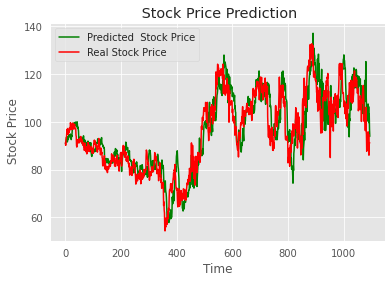

In [ ]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data2.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [ ]:
# Converting model from HDF5 format to TFJS format...
!pip install tensorflowjs[wizard]
# Need to be done on a CLI and not in notebook
!tensorflowjs_converter --input_format=keras /kaggle/working/model.h5 /kaggle/working/model-tjs

2021-12-28 04:28:46.375653: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# EDA

This section is exploratory data analysis on the dataset collected. This is just for analysing the data...

In [ ]:
dataX = pd.read_csv('./data.csv')
dataY = pd.read_csv('./data.csv')
dataX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5575 entries, 0 to 5574
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5575 non-null   int64  
 1   open        5575 non-null   float64
 2   high        5575 non-null   float64
 3   low         5575 non-null   float64
 4   close       5575 non-null   float64
 5   volume      5575 non-null   int64  
 6   date        5575 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 305.0+ KB


In [ ]:
dataX.head()

,Unnamed: 0,open,high,low,close,volume,date
0,0,130.63,131.6500,129.95,131.62,4294499,2021-12-27
1,1,130.00,130.9600,129.52,130.63,3649044,2021-12-23
2,2,129.06,129.7900,127.60,129.75,3923198,2021-12-22
3,3,127.66,129.3356,127.66,128.97,4855972,2021-12-21
4,4,125.72,127.2000,124.70,127.06,4941411,2021-12-20


In [ ]:
start_date = '2020-01-01'
end_date = '2021-11-29'

start = '2018-01-01'
end = '2020-01-01'

fill = (dataX['date']>=start_date) & (dataX['date']<=end_date)
dataX = dataX.loc[fill]
dataX

,Unnamed: 0,open,high,low,close,volume,date
19,19,118.62,119.610,117.53,118.50,8949795,2021-11-29
20,20,115.00,116.335,114.56,115.81,3322012,2021-11-26
21,21,116.16,117.270,116.08,116.73,3220802,2021-11-24
22,22,116.79,117.940,116.04,116.79,4914995,2021-11-23
23,23,116.00,118.810,115.19,116.47,6417218,2021-11-22
...,...,...,...,...,...,...,...
496,496,134.51,135.860,133.92,135.31,4345952,2020-01-08
497,497,133.69,134.960,133.40,134.19,3267592,2020-01-07
498,498,133.42,134.240,133.20,134.10,2421128,2020-01-06
499,499,133.57,134.860,133.56,134.34,2373470,2020-01-03


In [ ]:
fill2 = (dataY['date']>=start) & (dataY['date']<=end)
dataY = dataY.loc[fill2]
dataY

,Unnamed: 0,open,high,low,close,volume,date
501,501,132.53,134.12,132.40,134.04,3777504,2019-12-31
502,502,135.20,135.30,132.50,132.81,4118929,2019-12-30
503,503,135.00,135.75,134.87,135.27,2752185,2019-12-27
504,504,134.98,135.31,134.65,134.91,2129654,2019-12-26
505,505,135.61,135.62,134.61,134.98,1202087,2019-12-24
...,...,...,...,...,...,...,...
999,999,162.66,163.91,161.70,163.47,5101023,2018-01-08
1000,1000,162.44,162.90,161.10,162.49,5162075,2018-01-05
1001,1001,159.65,162.32,159.37,161.70,7363843,2018-01-04
1002,1002,157.34,159.81,156.33,158.49,9439063,2018-01-03


In [ ]:
dataX.describe()

,Unnamed: 0,open,high,low,close,volume
count,482.000000,482.000000,482.000000,482.000000,482.000000,4.820000e+02
mean,259.500000,129.382080,130.691720,128.092867,129.364751,5.454950e+06
std,139.285678,11.382857,11.114856,11.592091,11.353678,3.339331e+06
min,19.000000,94.600000,97.740000,90.560000,94.770000,1.761122e+06
25%,139.250000,121.250000,122.623500,120.102500,121.105000,3.644222e+06
50%,259.500000,126.325000,127.320000,125.045000,126.160000,4.655173e+06
75%,379.750000,139.672500,140.467500,138.757500,139.572500,6.115408e+06
max,500.000000,156.820000,158.750000,155.420000,156.760000,3.806353e+07


In [ ]:
dataY.describe()

,Unnamed: 0,open,high,low,close,volume
count,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02
mean,752.000000,140.470239,141.512740,139.348929,140.416143,4.590926e+06
std,145.347859,11.156349,11.144803,11.149435,11.121441,2.880224e+06
min,501.000000,108.000000,111.000000,105.940000,107.570000,1.202087e+06
25%,626.500000,134.485000,135.305000,133.570000,134.360000,3.067226e+06
50%,752.000000,140.720000,141.780000,139.790000,140.850000,3.783614e+06
75%,877.500000,146.635000,147.300000,145.540000,146.385000,5.033500e+06
max,1003.000000,170.000000,171.130000,168.150000,169.120000,2.206367e+07


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


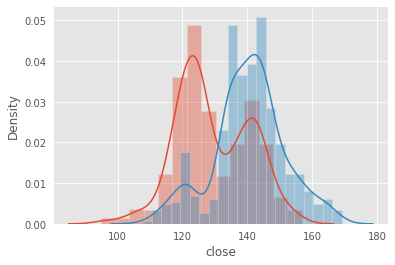

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error

sns_plot = sns.distplot(dataX['close'])
sns_plot2 = sns.distplot(dataY['close'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

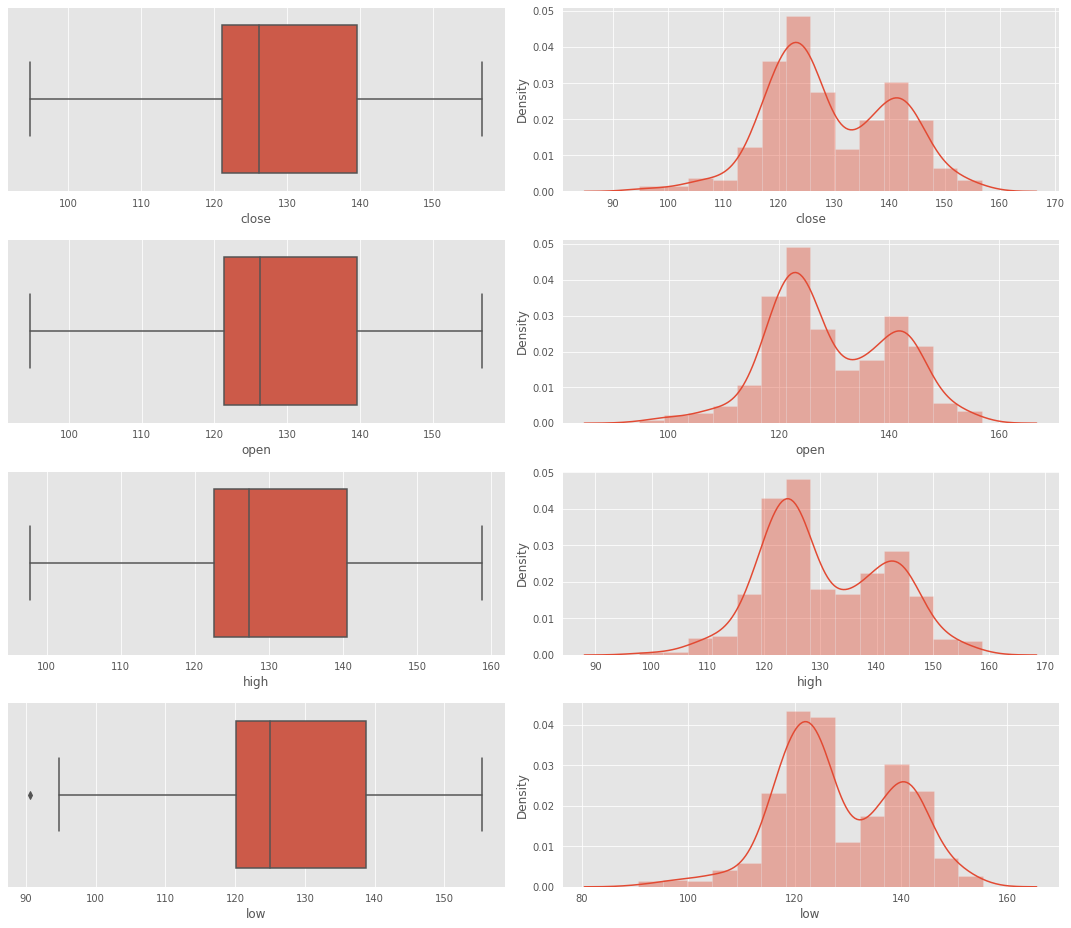

In [ ]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataX["close"], ax = ax[0,0])
sns.distplot(dataX['close'], ax = ax[0,1])
sns.boxplot(x= dataX["open"], ax = ax[1,0])
sns.distplot(dataX['open'], ax = ax[1,1])
sns.boxplot(x= dataX["high"], ax = ax[2,0])
sns.distplot(dataX['high'], ax = ax[2,1])
sns.boxplot(x= dataX["low"], ax = ax[3,0])
sns.distplot(dataX['low'], ax = ax[3,1])
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

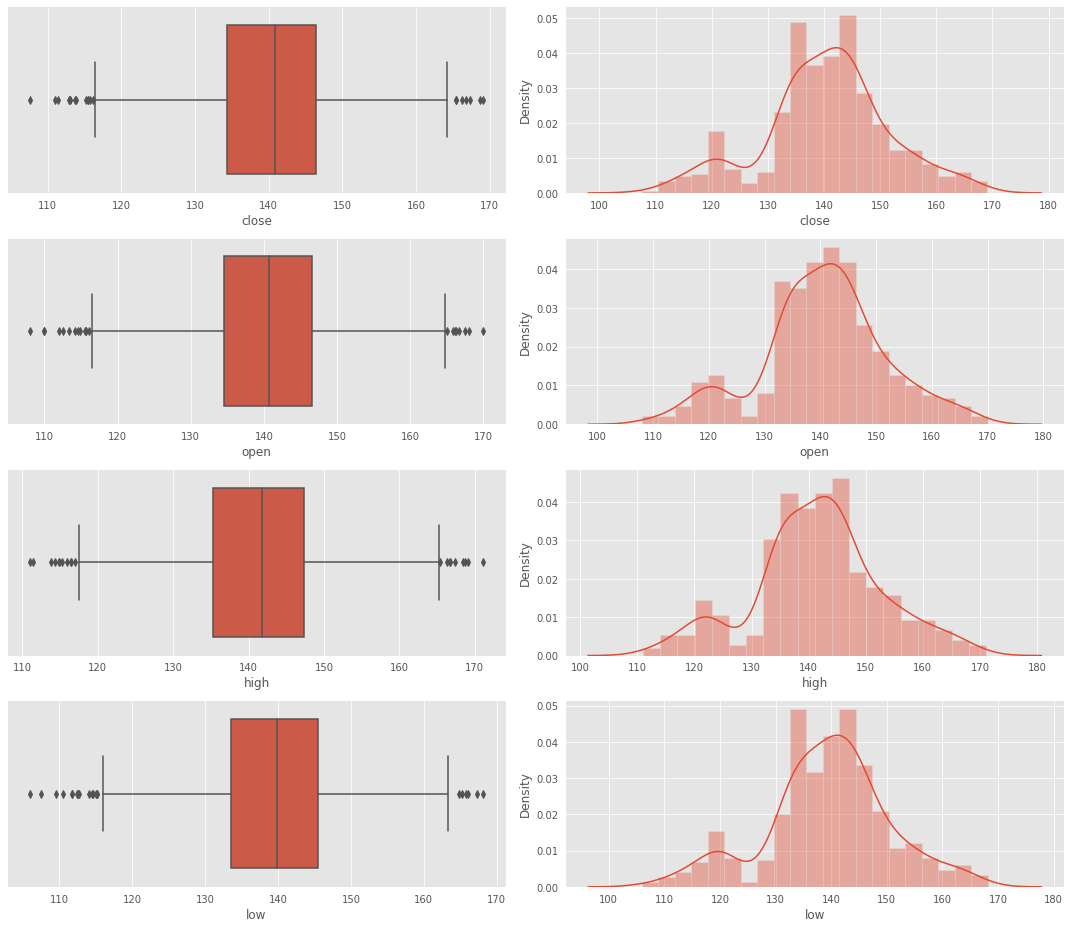

In [ ]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataY["close"], ax = ax[0,0])
sns.distplot(dataY['close'], ax = ax[0,1])
sns.boxplot(x= dataY["open"], ax = ax[1,0])
sns.distplot(dataY['open'], ax = ax[1,1])
sns.boxplot(x= dataY["high"], ax = ax[2,0])
sns.distplot(dataY['high'], ax = ax[2,1])
sns.boxplot(x= dataY["low"], ax = ax[3,0])
sns.distplot(dataY['low'], ax = ax[3,1])
plt.tight_layout()

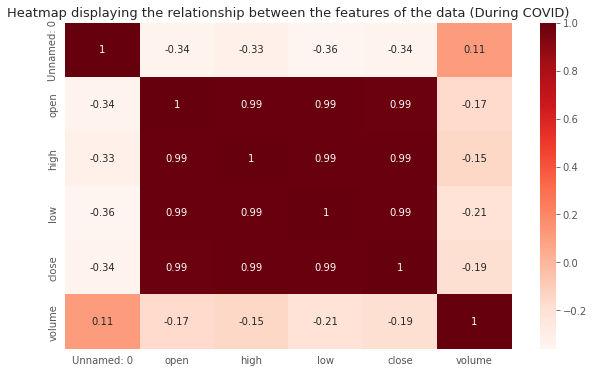

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(dataX.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (During COVID)',
         fontsize=13)
plt.show()

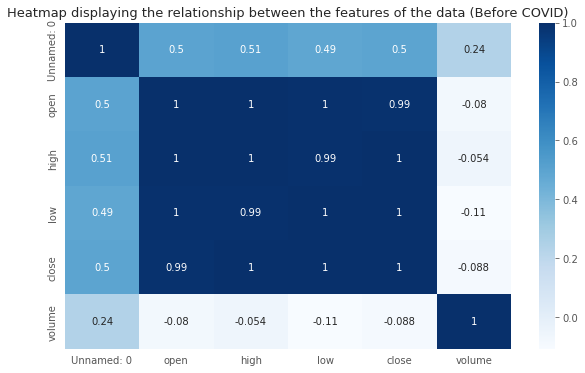

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(dataY.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (Before COVID)',
         fontsize=13)
plt.show()

In [ ]:
# For other company....

# UNCOMMENT IF NEEDED...
#cv2 = request_stock_price_list('RELIANCE.BSE', 'full', key)
#print(cv2.head)
#cv2.to_csv('data2.csv')

dataX = pd.read_csv('./data2.csv')
dataY = pd.read_csv('./data2.csv')
dataX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4184 entries, 0 to 4183
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4184 non-null   int64  
 1   open        4184 non-null   float64
 2   high        4184 non-null   float64
 3   low         4184 non-null   float64
 4   close       4184 non-null   float64
 5   volume      4184 non-null   int64  
 6   date        4184 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 228.9+ KB


In [ ]:
start_date = '2020-01-01'
end_date = '2021-11-29'

start = '2018-01-01'
end = '2020-01-01'

fill = (dataX['date']>=start_date) & (dataX['date']<=end_date)
dataX = dataX.loc[fill]
dataX

,Unnamed: 0,open,high,low,close,volume,date
20,20,2412.0000,2500.0000,2400.0000,2442.5000,451870,2021-11-29
21,21,2470.0000,2477.4500,2403.0000,2412.1499,397321,2021-11-26
22,22,2375.5000,2502.8000,2358.0000,2494.3999,476931,2021-11-25
23,23,2381.3999,2410.8501,2344.0000,2350.8999,1856369,2021-11-24
24,24,2339.0000,2401.5000,2309.3999,2386.1499,457139,2021-11-23
...,...,...,...,...,...,...,...
489,489,1519.9995,1533.9995,1514.4495,1525.0495,509038,2020-01-07
490,490,1526.9995,1527.9995,1497.4995,1501.4995,457443,2020-01-06
491,491,1534.3995,1541.2995,1523.3995,1537.2495,357456,2020-01-03
492,492,1513.9995,1540.7995,1512.9995,1535.3495,733200,2020-01-02


In [ ]:
fill2 = (dataY['date']>=start) & (dataY['date']<=end)
dataY = dataY.loc[fill2]
dataY

,Unnamed: 0,open,high,low,close,volume,date
493,493,1516.0995,1527.3995,1505.3495,1509.6995,461171,2020-01-01
494,494,1544.6995,1544.6995,1509.0995,1514.0995,298520,2019-12-31
495,495,1542.9995,1546.9995,1528.2995,1544.1995,374974,2019-12-30
496,496,1524.9995,1545.7995,1521.4495,1542.1495,490080,2019-12-27
497,497,1545.9495,1553.2995,1510.9495,1515.9495,582675,2019-12-26
...,...,...,...,...,...,...,...
978,978,920.4997,925.8497,919.4497,922.9997,410556,2018-01-05
979,979,918.9997,921.7997,915.9997,920.2497,241196,2018-01-04
980,980,924.4497,927.1997,913.2997,916.3497,520663,2018-01-03
981,981,914.9997,919.1997,907.2497,911.3997,1779802,2018-01-02


In [ ]:
dataX.describe()

,Unnamed: 0,open,high,low,close,volume
count,474.000000,474.000000,474.000000,474.000000,474.000000,4.740000e+02
mean,256.500000,1953.239692,1977.124080,1925.387901,1949.614691,1.148593e+06
std,136.976275,378.827940,377.669256,377.601744,377.490721,6.773073e+06
min,20.000000,919.999700,951.999700,875.699700,883.849700,6.484700e+04
25%,138.250000,1731.837500,1754.662500,1714.137500,1729.987500,2.998212e+05
50%,256.500000,2013.850000,2045.550000,1990.925000,2007.300000,4.758745e+05
75%,374.750000,2170.825000,2194.675000,2139.500000,2167.175000,9.260610e+05
max,493.000000,2740.000000,2750.000000,2708.000000,2731.500000,1.187279e+08


In [ ]:
dataY.describe()

,Unnamed: 0,open,high,low,close,volume
count,490.00000,490.000000,490.000000,490.000000,490.000000,4.900000e+02
mean,737.50000,1182.485761,1194.496168,1168.685966,1181.144638,5.672558e+05
std,141.59508,185.207018,186.587684,182.842687,184.419946,5.363404e+05
min,493.00000,879.999700,895.999700,872.099700,882.799700,1.488160e+05
25%,615.25000,999.624700,1012.524700,990.762200,1002.462200,3.096382e+05
50%,737.50000,1207.499600,1223.449600,1195.999600,1210.324600,4.345385e+05
75%,859.75000,1297.999600,1314.699600,1283.862100,1296.824600,6.224218e+05
max,982.00000,1611.199500,1617.799500,1595.649500,1605.149500,6.718394e+06


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


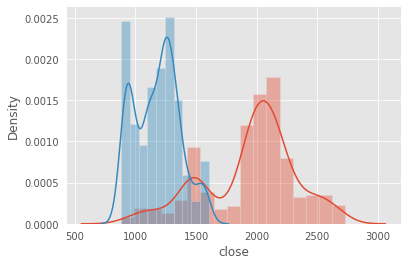

In [ ]:
sns_plot = sns.distplot(dataX['close'])
sns_plot2 = sns.distplot(dataY['close'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

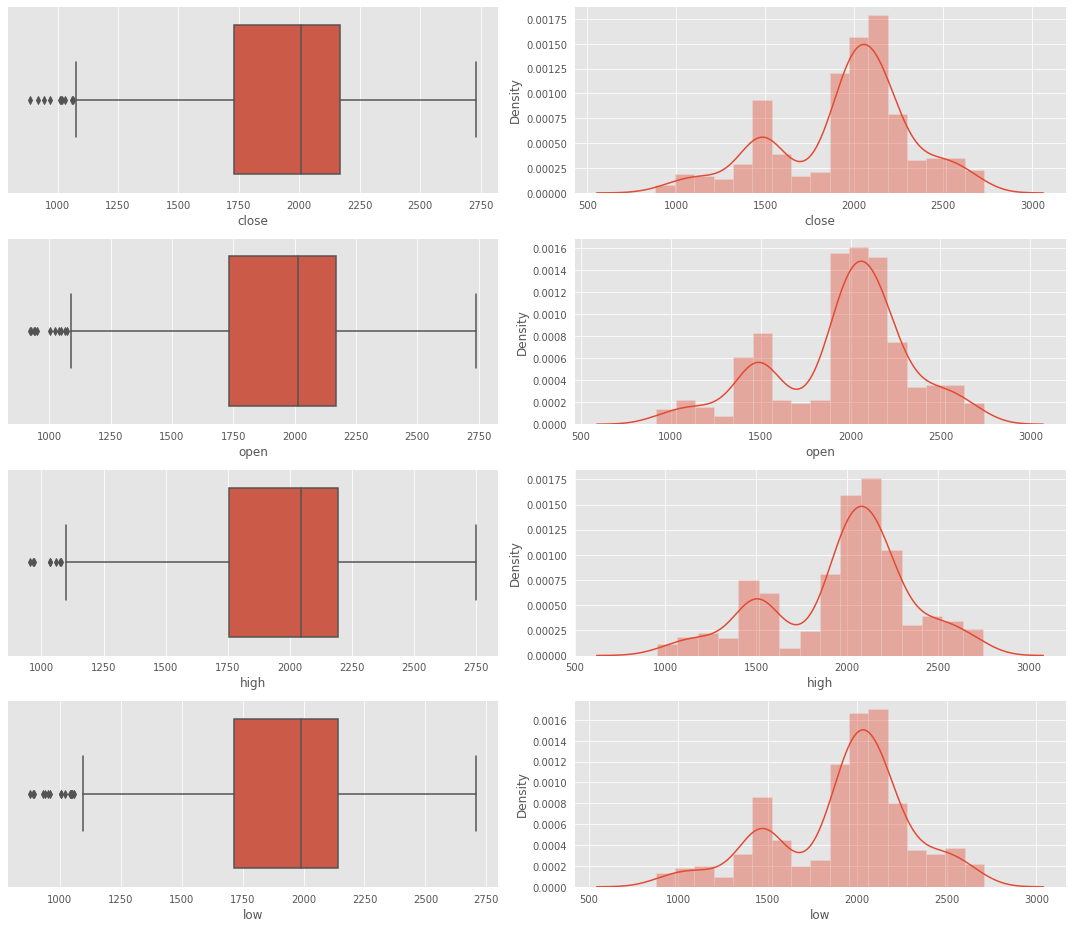

In [ ]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataX["close"], ax = ax[0,0])
sns.distplot(dataX['close'], ax = ax[0,1])
sns.boxplot(x= dataX["open"], ax = ax[1,0])
sns.distplot(dataX['open'], ax = ax[1,1])
sns.boxplot(x= dataX["high"], ax = ax[2,0])
sns.distplot(dataX['high'], ax = ax[2,1])
sns.boxplot(x= dataX["low"], ax = ax[3,0])
sns.distplot(dataX['low'], ax = ax[3,1])
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

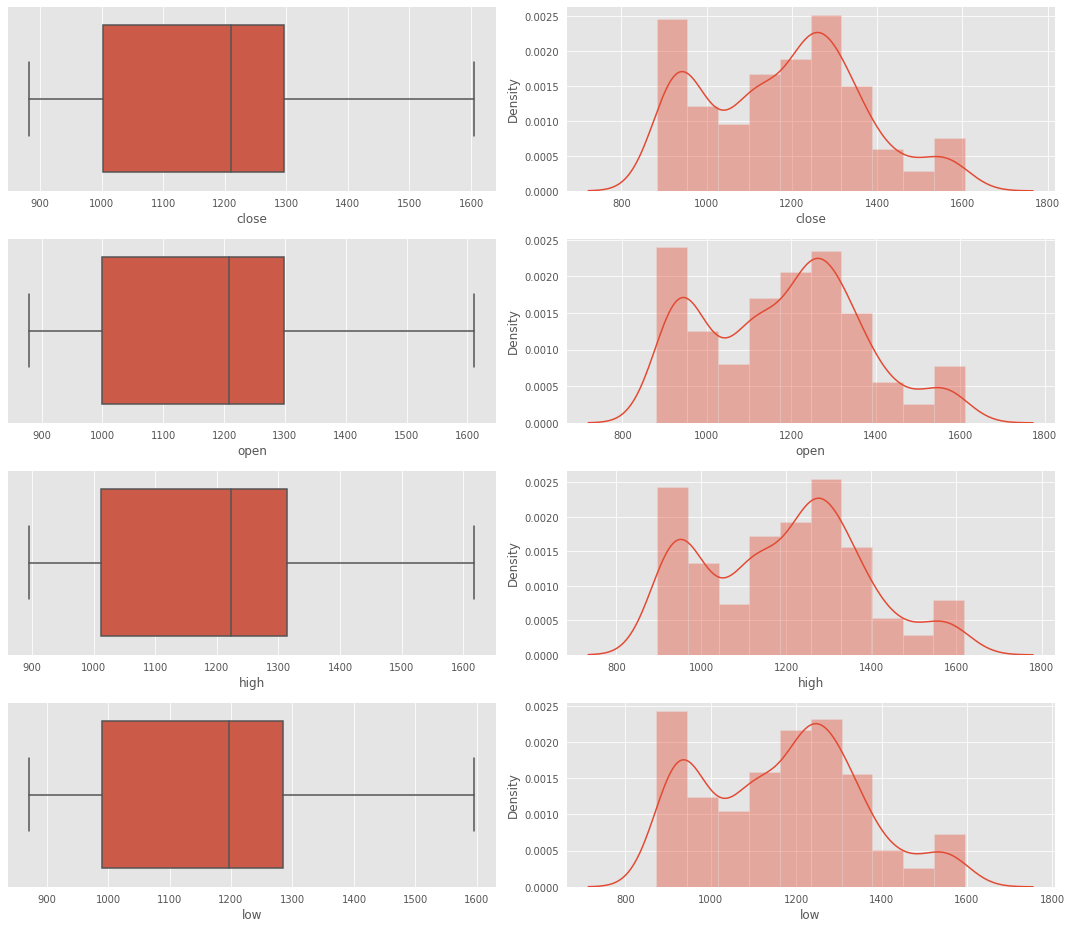

In [ ]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataY["close"], ax = ax[0,0])
sns.distplot(dataY['close'], ax = ax[0,1])
sns.boxplot(x= dataY["open"], ax = ax[1,0])
sns.distplot(dataY['open'], ax = ax[1,1])
sns.boxplot(x= dataY["high"], ax = ax[2,0])
sns.distplot(dataY['high'], ax = ax[2,1])
sns.boxplot(x= dataY["low"], ax = ax[3,0])
sns.distplot(dataY['low'], ax = ax[3,1])
plt.tight_layout()

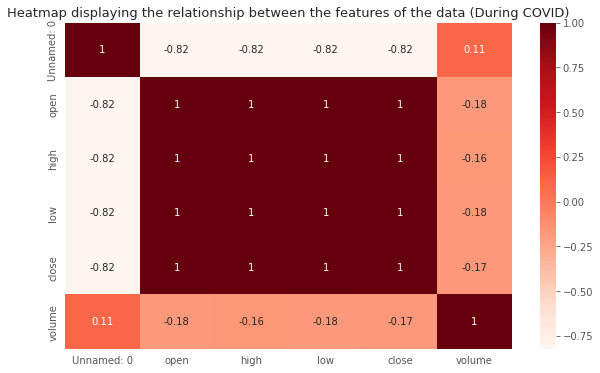

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(dataX.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (During COVID)',
         fontsize=13)
plt.show()

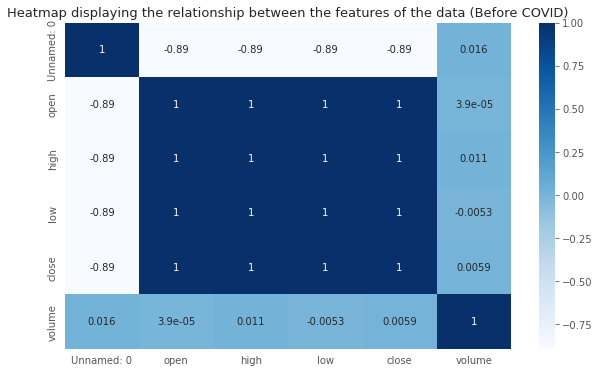

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(dataY.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (Before COVID)',
         fontsize=13)
plt.show()